In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = 25

class Portfolio:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the Portfolio with a list of tickers and date range.

        Parameters:
            tickers: A list of ticker symbols for the stocks.
            start_date: The start date for the historical price data (YYYY-MM-DD).
            end_date: The end date for the historical price data (YYYY-MM-DD).
        """

        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}


    def __repr__(self):
        return f"Fetching data for the following tickers: {self.tickers} from {self.start_date} to {self.end_date}"
    

    def fetch_data(self):
        """
        Fetch the historical price data for all tickers.
        """

        for ticker in self.tickers:
            try:
                stock = yf.Ticker(ticker)
                stock_info = stock.info
                if 'longName' not in stock_info:
                    raise ValueError(f"Invalid ticker: {ticker}")
                self.data[ticker] = stock.history(start=self.start_date, end=self.end_date, auto_adjust=True)
                # Convert DateTime Index to Date format
                self.data[ticker].index = self.data[ticker].index.date
            except Exception as e:
                print(f"Error fetching data for {ticker}: \n\t{e}")


    def display_ticker_data(self, ticker):
        """
        Display the historical price data for a specific ticker.
        """

        if ticker in self.data and self.data[ticker] is not None:
            display(self.data[ticker].head(10))
        else:
            print(f"No data found for ticker: {ticker}")
    

    def get_ticker_data(self, ticker):
        """
        Get the historical price data for a specific ticker.

        Parameters:
            ticker: The ticker symbol for the stock.
        Returns:
            A pandas DataFrame containing the historical price data for the stock.
        """

        if not self.data:
            self.fetch_data()

        self.display_ticker_data(ticker)
        
        return self.data.get(ticker, None)
    

    def render_price_vectors(self):
        """
        Render the adjusted close price vectors for all tickers in one dataframe.

        Returns:
            A pandas DataFrame containing the adjusted close price vectors for all tickers.
        """

        price_vectors = pd.DataFrame()

        if not self.data:
            self.fetch_data()

        for ticker, df in self.data.items():
            price_vectors[ticker] = df['Close']
        
        return price_vectors
    

    def compute_returns(self):
        """
        Compute the daily returns for all tickers.

        Returns:
            A pandas DataFrame containing the daily percent returns for all tickers.
        """

        prices = self.render_price_vectors()
        log_returns = np.log(prices / prices.shift(1))
        
        return log_returns
    

    def compute_cov_matrix(self):
        """
        Compute the covariance matrix for all tickers.

        Returns:
            A pandas DataFrame containing the covariance matrix for all tickers.
        """

        returns = self.compute_returns()
        cov_matrix = returns.cov()
        
        return cov_matrix
    
    
    def plot_corr_heatmap(self):
        """
        Plot a heatmap of the correlation matrix of returns for all tickers.
        """
        
        corr_matrix = self.compute_returns().corr()
        sns.heatmap(corr_matrix, annot=True, cmap='vlag', cbar=0, fmt=".0%", mask=np.triu(corr_matrix, k=1))
        plt.title("Correlation Matrix of Returns")
        plt.show()

    def generate_random_weights(self):
        """
        Generate random weights for the assets in the portfolio.

        Returns:
            A numpy array of random weights for the assets.
        """
    
        num_assets = len(self.tickers)
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        return weights


    def portfolio_return(self, weights):
        """
        Compute the expected return of the portfolio.

        Parameters:
            weights: A numpy array of weights for the assets in the portfolio.
        Returns:
            The expected return of the portfolio.
        """

        if 1-np.sum(weights) > 1e-5:
            raise ValueError("Portfolio weights must sum to 1")
        
        expected_return = self.compute_returns().mean() @ weights * 252 # Annualizing returns

        return expected_return
    

    def portfolio_volatility(self, weights):
        """
        Compute the volatility of the portfolio.

        Parameters:
            weights: A numpy array of weights for the assets in the portfolio.
        Returns:
            The standard deviation of the portfolio.
        """

        if 1-np.sum(weights) > 1e-5:
            raise ValueError("Portfolio weights must sum to 1")
        
        cov_matrix = self.compute_cov_matrix()

        # Portfolio variance = w^T * Covariance Matrix * w
        daily_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        annualized_volatility = daily_volatility * np.sqrt(252)
        return annualized_volatility
    

    def portfolio_sharpe_ratio(self, weights, risk_free_rate=0.03):
        """
        Compute the Sharpe ratio of the portfolio.

        Parameters:
            weights: A numpy array of weights for the assets in the portfolio.
            risk_free_rate: The risk-free rate of return.
        Returns:
            The Sharpe ratio of the portfolio.
        """

        expected_return = self.portfolio_return(weights)
        std_dev = self.portfolio_volatility(weights)

        sharpe_ratio = (expected_return - risk_free_rate) / std_dev

        return sharpe_ratio
    
    
    def display_efficient_frontier(self, num_portfolios=10000, risk_free_rate=0.01):
        num_assets = len(self.tickers)
        results = np.zeros((3, num_portfolios))
        mean_returns = self.compute_returns().mean()
        cov_matrix = self.compute_cov_matrix()
        
        for i in range(num_portfolios):
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            
            portfolio_return = np.dot(weights, mean_returns) * 252  # Annualizing returns
            portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualizing volatility
            
            results[0, i] = portfolio_std_dev
            results[1, i] = portfolio_return
            results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Sharpe Ratio

        plt.figure(figsize=(10, 7))
        plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        plt.title('Efficient Frontier')
        plt.show()

    # Now we will implement the Markowitz Portfolio Optimization (MVO) algorithm to find the optimal weights for the portfolio that maximizes the Sharpe ratio.
    def minimize_volatility(self, target_return):
        """
        Minimize the volatility of the portfolio for a given target return.

        Parameters:
            target_return: The target return for the portfolio.
        Returns:
            A tuple containing the minimum volatility and the optimal weights for the assets.
        """

        num_assets = len(self.tickers)
        mean_returns = self.compute_returns().mean()
        cov_matrix = self.compute_cov_matrix()

        def objective_function(weights):
            return self.portfolio_volatility(weights)

        def constraint_function(weights):
            return self.portfolio_return(weights) - target_return

        initial_guess = np.repeat(1/num_assets, num_assets)
        bounds = [(0, 1) for _ in range(num_assets)]
        constraints = ({'type': 'eq', 'fun': constraint_function},
                       {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        min_volatility = result.fun
        optimal_weights = result.x

        return min_volatility, optimal_weights

In [2]:
portfolio_tickers = ['AAPL', 'TSLA', 'META', 'AMZN', 'NFLX', 'LNG', 'XOM', 'VLO', 'HD','CAT']

start_date = '2023-01-01'
end_date = '2023-12-31'

,AAPL,TSLA,META,AMZN,NFLX,LNG,XOM,VLO,HD,CAT
AAPL,0.00016,0.00018,0.00016,0.00011,0.00012,0.00003,0.00002,0.00001,0.00007,0.00006
TSLA,0.00018,0.00109,0.00031,0.00026,0.00022,0.00005,-0.00000,0.00003,0.00012,0.00015
META,0.00016,0.00031,0.00058,0.00029,0.00019,-0.00000,-0.00002,-0.00000,0.00010,0.00005
AMZN,0.00011,0.00026,0.00029,0.00043,0.00018,0.00001,-0.00002,-0.00000,0.00010,0.00003
NFLX,0.00012,0.00022,0.00019,0.00018,0.00054,0.00002,0.00001,-0.00001,0.00008,0.00008
LNG,0.00003,0.00005,-0.00000,0.00001,0.00002,0.00028,0.00013,0.00014,0.00004,0.00009
XOM,0.00002,-0.00000,-0.00002,-0.00002,0.00001,0.00013,0.00025,0.00019,0.00005,0.00011
VLO,0.00001,0.00003,-0.00000,-0.00000,-0.00001,0.00014,0.00019,0.00042,0.00004,0.00014
HD,0.00007,0.00012,0.00010,0.00010,0.00008,0.00004,0.00005,0.00004,0.00018,0.00010
CAT,0.00006,0.00015,0.00005,0.00003,0.00008,0.00009,0.00011,0.00014,0.00010,0.00032


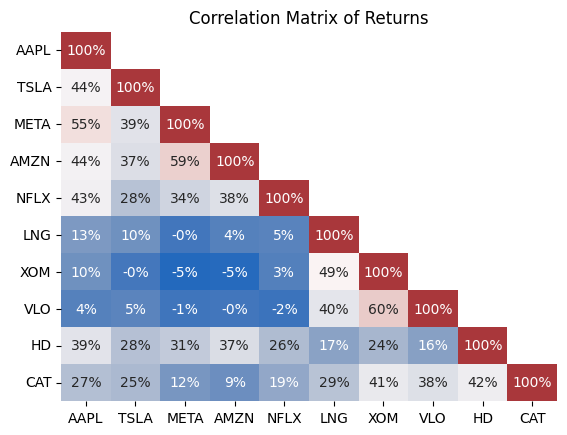

Expected Return of the Portfolio: 38.76%
Volatility of the Portfolio: 18.95%
Sharpe Ratio of the Portfolio: 1.8868


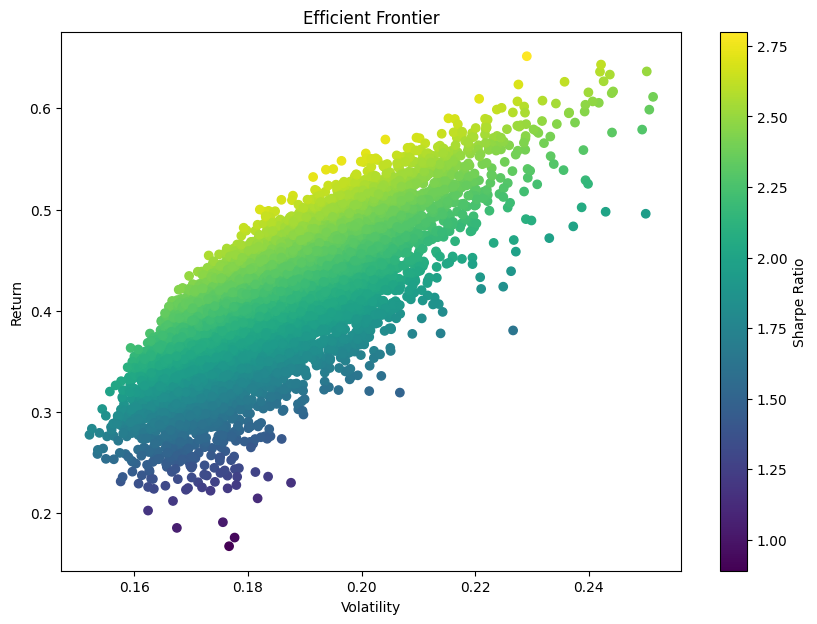

Minimum Volatility for Target Return of 40.00%: 15.91%

Optimal Weights:
	AAPL: 0.3910
	TSLA: 0.0000
	META: 0.1133
	AMZN: 0.0523
	NFLX: 0.0327
	LNG: 0.1730
	XOM: 0.0540
	VLO: 0.0703
	HD: 0.0727
	CAT: 0.0407

Expected Return of Optimized Portfolio: 40.00%
Volatility of Optimized Portfolio: 15.91%
Sharpe Ratio of Optimized Portfolio: 2.3249


In [3]:
portfolio = Portfolio(portfolio_tickers, start_date, end_date)

covariances = portfolio.compute_cov_matrix()
display(covariances.style.set_caption("Covariance Matrix of Returns").format("{:.5f}"))

portfolio.plot_corr_heatmap()

# Initialize random weights for the assets in our mock portfolio
weights = portfolio.generate_random_weights()

# Compute the expected return of the portfolio
expected_return = portfolio.portfolio_return(weights)
print(f"Expected Return of the Portfolio: {expected_return:.2%}")

volatility = portfolio.portfolio_volatility(weights)
print(f"Volatility of the Portfolio: {volatility:.2%}")

sharpe_ratio = portfolio.portfolio_sharpe_ratio(weights)
print(f"Sharpe Ratio of the Portfolio: {sharpe_ratio:.4f}")

portfolio.display_efficient_frontier()

# Find the optimal weights for the portfolio that minimizes the volatility for a given target return
target_return = 0.4
min_volatility, optimal_weights = portfolio.minimize_volatility(target_return)
print(f"Minimum Volatility for Target Return of {target_return:.2%}: {min_volatility:.2%}")
print("\nOptimal Weights:")
for ticker, weight in zip(portfolio_tickers, optimal_weights):
    print(f"\t{ticker}: {weight:.4f}")

# Compute the expected return and volatility of the optimized portfolio
optimized_return = portfolio.portfolio_return(optimal_weights)
optimized_volatility = portfolio.portfolio_volatility(optimal_weights)
optimized_sharpe_ratio = portfolio.portfolio_sharpe_ratio(optimal_weights)
print(f"\nExpected Return of Optimized Portfolio: {optimized_return:.2%}")
print(f"Volatility of Optimized Portfolio: {optimized_volatility:.2%}")
print(f"Sharpe Ratio of Optimized Portfolio: {optimized_sharpe_ratio:.4f}")